In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Cleaning the data

In [56]:
raw_df = pd.read_excel('Official FI Survey Raw Data Lightly Cleaned.xlsx')
raw_df = raw_df.drop('Index', axis = 1)

In [57]:
pd.set_option('display.max_columns', None)
raw_df.head()

,Gender,Age,Household income contributors,Relationship Status,Finances combined,Plan to have children,Number of intended children,Number dependents,FI,Year FI,Occupation,Unnamed: 12,Housing situation,Unnamed: 14,Have roommates,Country,Living environment,Unnamed: 18,COL index,Commute length,Citezenships,Highest Education,American Indian or Alaskan Native?,Asian or Pacific Islander?,Black or African American?,Hispanic or Latino?,White / Caucasian?,Prefer not to answer?,Caribbean?,Military - Active Duty or Veteran?,LGBTQ?,Learning disability?,Physical disability?,Mental illness?,Addiction?,Survivor of Abuse,Gross household annual wage income,Gross household annual side gig income,Gross household annual real estate income,Gross household annual investment income,Gross household annual other income,Household student debt,Student debt maturity,Student debt IR,Household credit card debt,Credit card debt maturity,Credit card IR,Household auto loan debt,Auto loan debt maturity,Auto loan IR,Household mortgage debt,Mortgage debt maturity,Mortgage debt IR,Household other debt,Other debt maturity,Other debt IR,NW excluding real estate,Value of primary residence,What did you do with windfall?,Unnamed: 60,Household annual expenditures on the following?,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66,Unnamed: 67,Unnamed: 68,Unnamed: 69,Unnamed: 70,Unnamed: 71,Unnamed: 72,Unnamed: 73,Unnamed: 74,Unnamed: 75,Unnamed: 76,Savings rate,Consider yourself FI number,Unnamed: 79,Percentage FI,When you reach FI...,Unnamed: 82,SWR,Projected real annual growth,Continue working full-time,Work part-time,Not work,Volunteer,Create new business,Continue my existing side gig?,N/A?,Unsure?,Continue working full-time.1,Work part-time.1,Not work.1,Volunteer.1,Create new business.1,Continue my existing side gig?.1,N/A?.1,Unsure?.1,What are your estate planning intentions?,Unnamed: 102,Unnamed: 103,How frequently do you check your balances?,Plan to move when FIRE,Childhood financial stability,Parent financial status,Parents taught about money,Age of financial literacy,Age learned about FIRE,NW when started toward FIRE,Assets when started toward FIRE,Debts when started toward FIRE,Consent of response release
0,Male,26,1,"In a relationship, but not married",Yes,Plan Children,2.0,NaN,No,NaN,"Licensed Professional (Attorney, Accountant, E...",NaN,Rent,NaN,No,United States of America,Suburban,NaN,"81-100 (San Jose, CA US; Portland OR US; Dubli...",30-60 minutes,United States,"College graduate, Bachelor's Degree",NaN,NaN,NaN,NaN,White / Caucasian,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110000.0,0.0,0.0,750.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,35000.0,0.0,NaN,NaN,19600.0,NaN,2000.0,NaN,NaN,500.0,1500.0,NaN,3000.0,1000.0,NaN,2000.0,1000.0,NaN,500.0,500.0,20.0,1500000,2500000,2.0,25.0,51,4.0,3.0,NaN,Work part-time,NaN,Volunteer,NaN,NaN,NaN,NaN,Continue working full-time,NaN,NaN,Volunteer,NaN,NaN,NaN,NaN,Leave inheritance for family,NaN,NaN,Weekly,"Yes, within my country",Mostly Stable,Middle Class,"No, we did not talk about it",15.0,18.0,20000.0,25000.0,0.0,Yes
1,Male,37,2,"In a relationship, but not married",Yes,Have Children,2.0,0.0,No,NaN,Legal Occupations,NaN,Own,NaN,No,Sweden,Suburban,NaN,"81-100 (San Jose, CA US; Portland OR US; Dubli...",30-60 minutes,NaN,Graduate degree,NaN,NaN,NaN,NaN,White / Caucasian,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,280000.0,0.0,0.0,0.0,0.0,30000.0,3000.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,244000.0,15000.0,0.7,0.0,0.0,0.0,9000.0,450000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45,55,10.0,NaN,45,4.0,NaN,NaN,Work part-time,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Work part-time,NaN,NaN,NaN,NaN,NaN,NaN,Leave inheritance for family,NaN,NaN,Daily,No,Somewhat Unstable,Middle Class,"No, they were not financially savvy",30.0,30.0,NaN,NaN,NaN,Yes
2,Male,20,1,"Single, never married",NaN,Undecided,NaN,0.0,No,NaN,Computer and Mathematical Occupations - Softwa...,NaN,Rent,NaN,Yes,United States of America

Looking at the survey answers, it's apparent that in some cases, each response choice is its own column--we'll consolidate some of these into single columns. 

In [58]:
# number of responses, features
raw_df.shape

(1378, 114)

(array([ 82., 227., 424., 276., 163., 117.,  54.,  22.,   9.,   4.]),
 array([30., 36., 42., 48., 54., 60., 66., 72., 78., 84., 90.]),
 <a list of 10 Patch objects>)

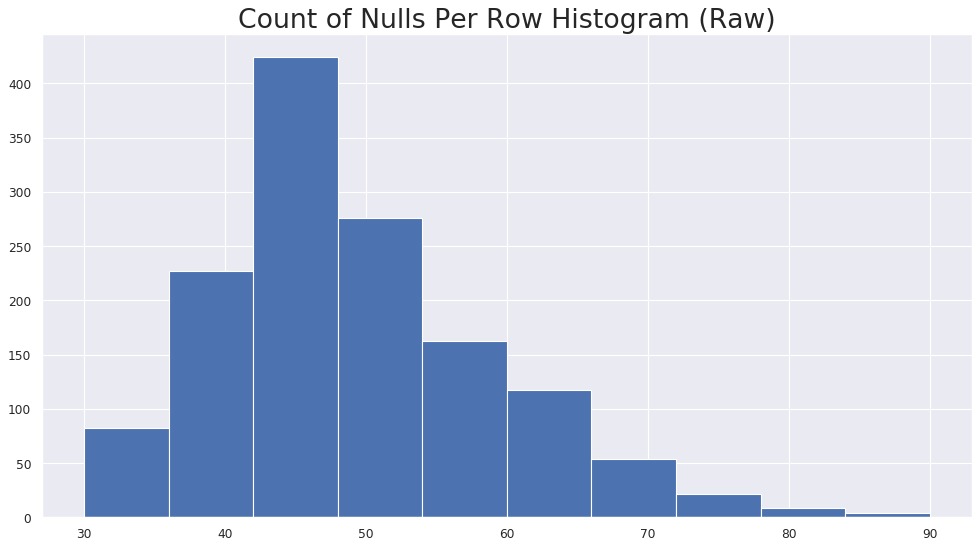

In [59]:
# number of missing values per row
figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title('Count of Nulls Per Row Histogram (Raw)', size=24)
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.hist(raw_df.isnull().sum(axis=1))

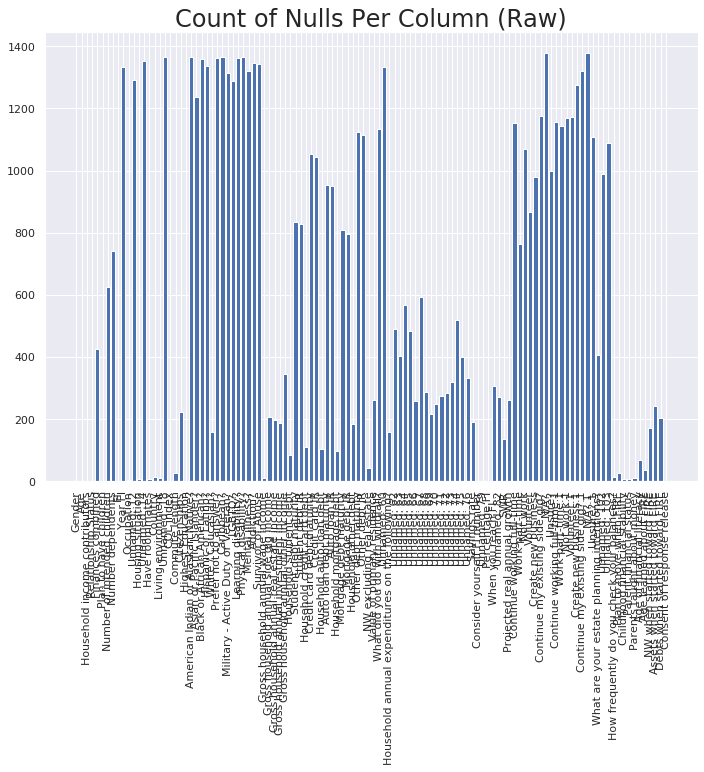

In [60]:
# Histogram of missing values per feature
x_len = len(raw_df.columns)
y_axis = []
x_axis = []

for col in raw_df.columns:
    null_col = raw_df[col].isnull().sum()
    y_axis.append(null_col)
    x_axis.append(col)


plt.xticks(rotation=90)
plt.bar(x_axis, y_axis)
plt.title('Count of Nulls Per Column (Raw)', size=24)
plt.show()

It looks like the typical row has ~45 nulls, which seems like a fairly high number given that there are 114 columns. There are also lots of columns that are almost completely null. We therefore need to get the features under control by consolidating and eliminating as necessary. 

In [61]:
# see whether Unnamed 12 is worth keeping

raw_df['Unnamed: 12'].loc[~raw_df['Unnamed: 12'].isnull()]

14                        Actuary
44                Pharmaceuticals
50                   Grad student
66                Medical Student
71                       Military
                  ...            
1313         Corrections officer 
1318                     Military
1325       Firefighter/Paramedic 
1335    Environmental Management 
1349                     Military
Name: Unnamed: 12, Length: 86, dtype: object

In [62]:
raw_df['Unnamed: 12'].unique()

array([nan, 'Actuary', 'Pharmaceuticals', 'Grad student',
       'Medical Student', 'Military', 'Marketing/eCommerce',
       'Financial data science', 'Student', 'Consulting',
       'Dental Student', 'Technical business analyst consultant',
       'Retail - grocery, assistant management', 'business owner ',
       'Active duty U.S. Navy', 'Energy industry management', 'Banking',
       'Strategy Consulting', 'Marketing company owner ', 'IT Auditor',
       'IT Risk Management', 'Power Plant Operations', 'Finance',
       'Military Officer', 'Government - Urban Planner',
       'Military - USAF Student Pilot', 'Non-life actuary ',
       'Energy Analyst / Consultant', 'Government',
       'Conscript in the armed forces', 'Fighter Pilot',
       'Aviation industry', 'US Army', 'student - electrical engineering',
       'Firefighter/Paramedic', 'Audit/program management',
       'Engineering Student', 'Program management', 'Telecommunications',
       'Fvhxdxxxxrf²¢,#¢', 'Retail', 'Self

There are 86 values in 'Unnamed: 12', and a lot of them are similar to each other. We'll try to consolidate them into buckets so that they're more useful if we want to use them.

In [64]:
military_gov = ['Military', 'Active duty U.S. Navy', 'Military Officer', 'Government - Urban Planner', 
                'Military - USAF Student Pilot', 'Government', 'Fighter Pilot', 'US Army', 'Firefighter/Paramedic',
               'Politics/government', 'military', 'Corrections officer ', 'Firefighter/Paramedic ']
student = ['Grad student', 'Medical Student', 'Student', 'Dental Student', 'student - electrical engineering',
              'Engineering Student', 'Graduate Student (Engineering)', ]
science_research = ['Pharmaceuticals', 'Clinical Research', 'Industrial/Organizational Psychologist', 'research',
                   'Chemical research', 'Chemical  engineer']

def occupation(x):
    """
    Sorts certain free-form responses to Occupation into three buckets
    Input: a cell in a column of a pandas dataframe (will be used via .apply() method)
    Output: standardized occupation bucket
    """ 
    
    if x in military_gov:
        x = 'Military/Gov'
    elif x in student:
        x = 'Student'
    elif x in science_research:
        x = 'Science/Research'
    else:
        x = 'Other'
    return x

raw_df['Unnamed: 12'] = raw_df['Unnamed: 12'].apply(occupation)

In [65]:
raw_df['Unnamed: 12'].unique()

array(['Other', 'Student'], dtype=object)

In [66]:
# Consolidate occupation responses spread across two columns into one

raw_df['Occupation'] = np.where(raw_df['Occupation']=='Other (please specify)', raw_df['Unnamed: 12'], raw_df['Occupation'])
raw_df['Housing situation'].loc[raw_df['Housing situation'] == 'Other (please specify)'] = 'Other'

# drop 'Unnamed: 12'
raw_df.drop(['Unnamed: 12'], axis =1, inplace=True)

In [67]:
# see whether 'Unnamed: 14' is worth keeping

raw_df['Unnamed: 14'].loc[~raw_df['Unnamed: 14'].isnull()]

130               Fiance owns the house, I pay him rent. 
223     Comped apartment in exchange for community eve...
230                       Live in a house owned by family
248              Cooperative housing (similar to renting)
284                                           Vandwelling
412         Own (wouldn't let me select Own as an option)
502        Live for free at one of my family's properties
566                                      Military Housing
706      Free rent but pay property taxes, utilities, etc
710          Rent primary residence, own rental property 
754     renting during the summer, dorm at school duri...
761                                         House sitting
811     Permanently traveling and living in hotels and...
814     Dorm during school year, anywhere else during ...
836                     Coop, own a share of corporation 
849                                                   van
853                                      Company provided
901     Curren

In [68]:
# There are only 14 free-from responses, and there are a variety, so we'll stick with calling these 'other'
# drop Unnamed: 12
raw_df = raw_df.drop(['Unnamed: 14'], axis =1)

In [69]:
# see whether Unnamed 18 is worth keeping
raw_df['Unnamed: 18'].loc[~raw_df['Unnamed: 18'].isnull()]

98                                             Small town
472                                            Small town
499                                           Albuquerque
528                                            Small town
661          Own condo in urban area and house in suburbs
811     Permanently traveling and living in hotels and...
991                                            Small town
1161                              visiting family+friends
1191                                           Small town
1204                                           Small town
1220                                        Military base
Name: Unnamed: 18, dtype: object

In [70]:
# Add "Small town", "Other" for the rest
raw_df['Living environment'].loc[raw_df['Unnamed: 18']=='Small town'] = 'Small town'
raw_df['Living environment'].loc[raw_df['Living environment']=='Other (please specify)'] = 'Other' 
raw_df = raw_df.drop(['Unnamed: 18'], axis =1)

In [71]:
# Combine the columns for race into one

raw_df['Race'] = np.nan

raw_df['Race'] =raw_df[raw_df.columns[19:26]].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1)

# Check the output
raw_df['Race'].head()

0            White / Caucasian
1            White / Caucasian
2            White / Caucasian
3    Asian or Pacific Islander
4            White / Caucasian
Name: Race, dtype: object

In [72]:
# drop the obsolete race columns
raw_df.drop(raw_df.columns[19:26], axis=1, inplace=True)

In [73]:
# Combine the various types of income into a "Total Income" field
raw_df['Total Income'] = raw_df.iloc[:,26:31].sum(axis=1) 

raw_df['Total Income'].head()

0    110750.0
1    280000.0
2    118000.0
3    150000.0
4     66200.0
Name: Total Income, dtype: float64

In [74]:
# Unnamed: 60 is an open field that offers further description--not useful for this analysis

raw_df.drop('Unnamed: 60', inplace=True, axis=1)

In [75]:
# "Household annual expenditures on the following?" and the following columns aren't labeled, so will remove
raw_df.drop(raw_df.columns[49:65], inplace=True, axis=1)

In [76]:
# Rename "Unnamed: 79", remove if less than 100K (not valid number)
raw_df.rename(columns={'Unnamed: 79':'RE Number'}, inplace=True)
raw_df['Consider yourself FI number'] =  raw_df['Consider yourself FI number'].apply(lambda x: x if x > 100000 else np.nan)
raw_df['RE Number'] =  raw_df['RE Number'].apply(lambda x: x if x > 100000 else np.nan)

In [77]:
# Rename columns, valid year dates
raw_df.rename(columns={'When you reach FI...':'Year of Expected FI', 'Unnamed: 82': 'Age of Expected FI'}, inplace=True)
raw_df['Age of Expected FI'].loc[raw_df['Age of Expected FI']=='Old'] = np.nan # removes a non-numeric entry

raw_df['Year of Expected FI'] =  raw_df['Year of Expected FI'].apply(lambda x: x if x > 1950 else np.nan)
raw_df['Age of Expected FI'] =  raw_df['Age of Expected FI'].apply(lambda x: x if x < 100 else np.nan)

In [79]:
# Get a sense of the values in 'SWR'
raw_df.SWR.unique()

array([4.000000e+00, 3.500000e+00, 5.000000e+00, 3.000000e+00,
       6.400000e+01,          nan, 2.000000e+00, 3.750000e+00,
       2.850000e+00, 4.500000e+00, 5.000000e+01, 7.000000e+00,
       3.333333e+00, 2.500000e+00, 7.500000e+01, 5.000000e-01,
       3.780000e+00, 0.000000e+00, 3.700000e+00, 3.900000e+00,
       3.650000e+00, 7.200000e+00, 3.600000e+00, 3.000000e-02,
       6.000000e+00, 3.300000e-01, 7.000000e-02, 1.000000e+01,
       5.500000e+00, 1.000000e+02, 9.000000e+01, 5.000000e-02,
       4.000000e+01, 4.200000e+00, 6.700000e+00, 4.000000e-02,
       3.300000e+00, 3.800000e+00, 3.333000e+00, 5.500000e-02,
       3.200000e+00, 1.900000e+00, 3.652500e+00, 1.000000e+00,
       6.500000e+01, 6.000000e-01, 2.800000e+00, 3.500000e-02,
       3.250000e+00, 3.330000e+00, 3.850000e+00, 2.220000e+00])

In [80]:
# need to combine estate plan columns into one--will make a list of strings

raw_df['Estate Plan'] =raw_df[raw_df.columns[73:76]].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1)

In [81]:
raw_df.drop(raw_df.columns[73:76], inplace=True, axis=1)

In [82]:
raw_df['Estate Plan'].head()

0             Leave inheritance for family
1             Leave inheritance for family
2                                         
3             Leave inheritance for family
4    Leave inheritance for family,Donation
Name: Estate Plan, dtype: object

In [83]:
# It's not entirely clear what the survey question was that corresponds to the columns below
# They're also riddled with null values, so we'll drop them as we're not going to use them.
raw_df.drop(raw_df.columns[57:73], inplace=True, axis=1)

In [31]:
# Saving the cleaned data 

clean_df = raw_df.copy()
clean_df.to_excel('Official FI Survey Data Fully Cleaned.xlsx')

In [32]:
df = pd.read_excel('Official FI Survey Data Fully Cleaned.xlsx')

In [86]:
print('Number of columns in cleaned dataframe: ' + str(len(df.columns)))

Number of columns in cleaned dataframe: 72


(array([ 43., 167., 208., 490., 277., 107.,  50.,  26.,   5.,   5.]),
 array([ 6., 10., 14., 18., 22., 26., 30., 34., 38., 42., 46.]),
 <a list of 10 Patch objects>)

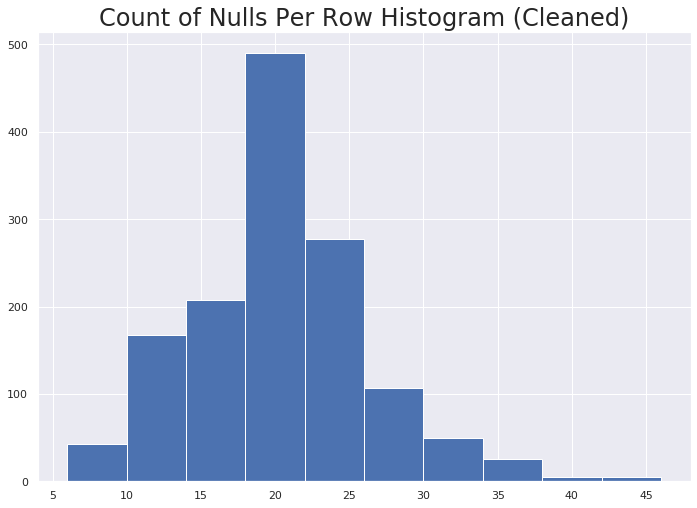

In [36]:
# number of missing values per row

plt.title('Count of Nulls Per Row Histogram (Cleaned)', size=24)
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.hist(clean_df.isnull().sum(axis=1))

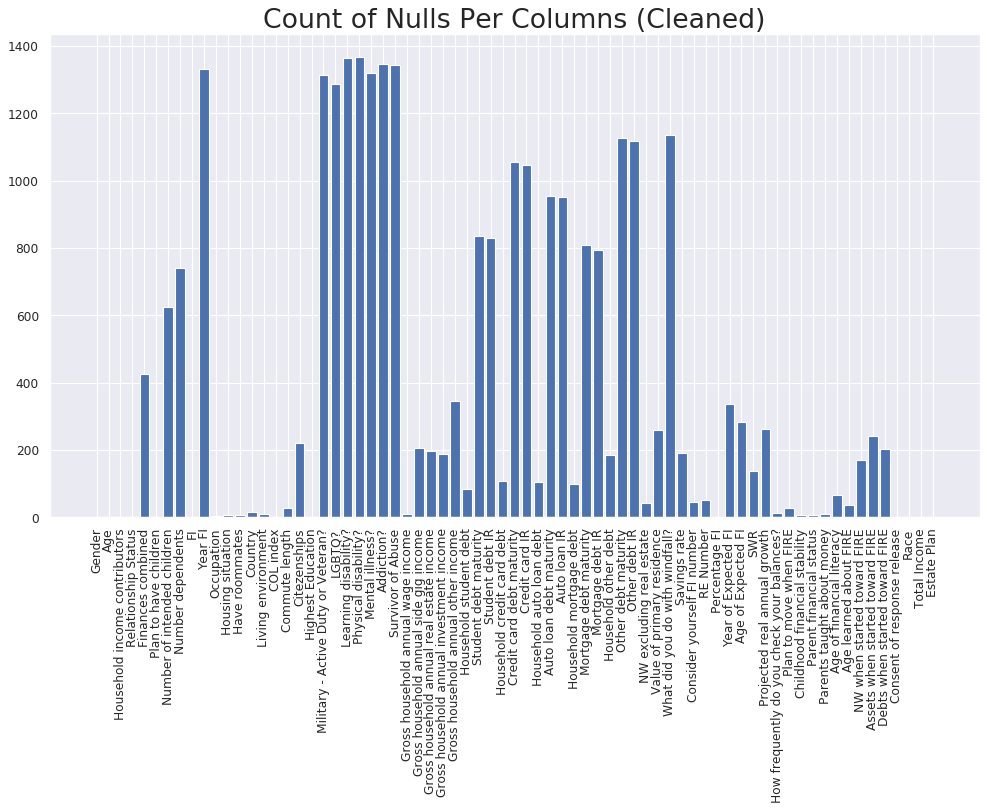

In [37]:
# Histogram of missing values 
x_len = len(clean_df.columns)
y_axis = []
x_axis = []

for col in clean_df.columns:
    null_col = clean_df[col].isnull().sum()
    y_axis.append(null_col)
    x_axis.append(col)


from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')

plt.xticks(rotation=90)
plt.bar(x_axis, y_axis)
plt.title('Count of Nulls Per Columns (Cleaned)', size=24)
plt.show()

The majority of the fields with a high number of missing values have to do with rare characteristics, FI status, and plans after FI/RE

After cleaning the dataset (removing, altering, and consolidating features), we reduced the number of columns from 115 to 72. The dataset can now be used for analysis. 

# Analysis

With this newly cleaned data, I aim to explore 3 questions:
    
    1) How do financial goals change as users get older?

    2) How does upbringing affect users’ financial well-being in adulthood?
    
    3) How does a given person compare to this group of users?


### Question 1: How do financial goals change as users get older?

I first performed a regression of the total asset amount that it takes for someone to consider themselves financially independent vs. their age. Several users submitted values that were clear outliers when examining the distributions, and therefore had to be removed. 

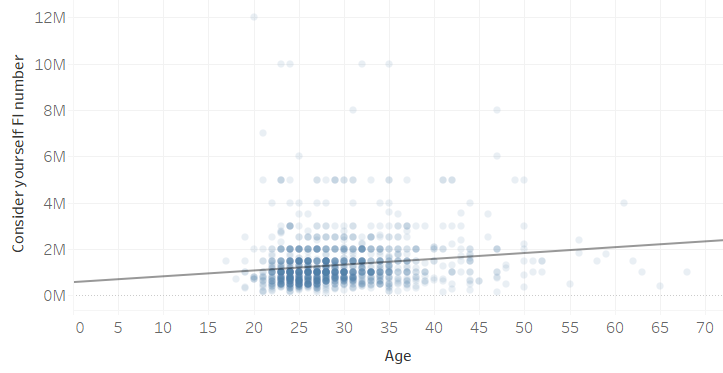


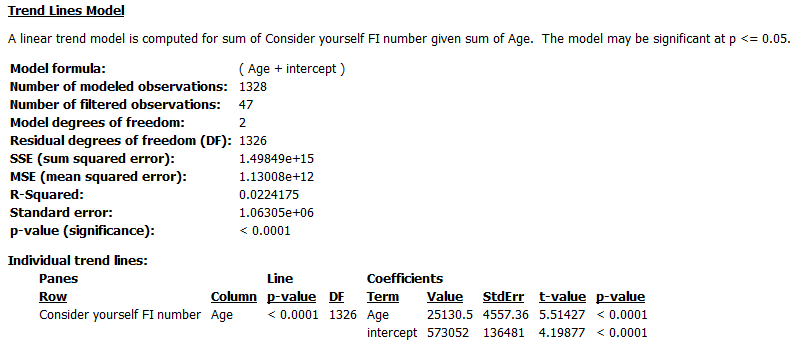

This yielded a positive and statstically significant (p-value far below .05) relationship between the two. According to the R2 value, age explains about 2% of the variance observed in people's target numbers. 

It's possible that some combination of lifestyle creep, increased number of dependents, or knowledge of future healthcare costs helps explain why we see this trend. 

If we evaluate what percentage of users either plan to, have, plan not to, or undecided about having children, we see some interesting trends: 

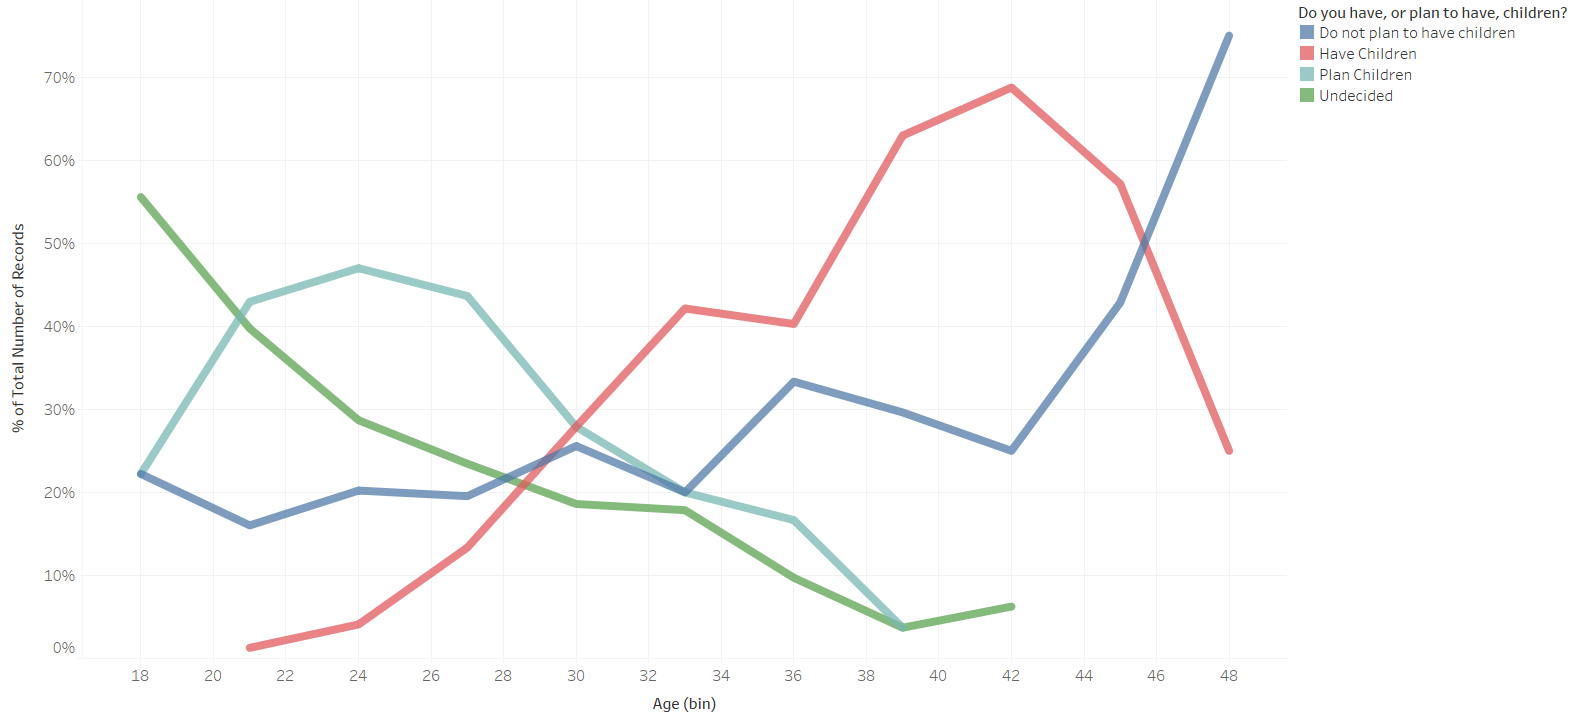

We see that as people get older, the percent who are undecided declines sharply as people figure out what they want--some will decide to have children, and some will realize they don't want them. Planning to have children becomes more and more common as people approach the age of 24, and then steadily declines as they (seemingly) go and have them. 

One would expect that as family plans solidify, people will adjust their projected financial needs accordingly. 

### 2) How does upbringing affect users’ financial well-being in adulthood?

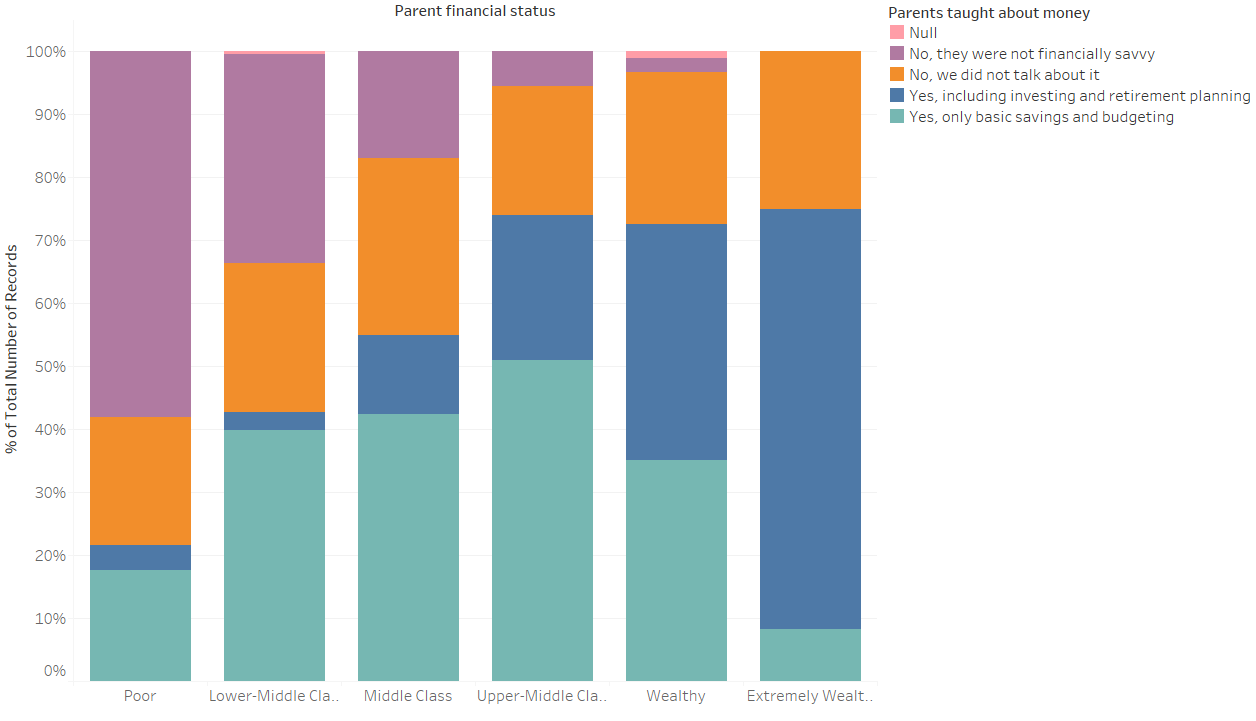

Here, the users are separated into buckets according to their parents' affluence, and evaluate the liklihood and degree to which they taught their child about finance. 

It's clear that wealthier parents are more likely than poorer ones to have knowledge regarding saving and investing, and are therefore mroe likely and able to share their advice. In particular, knowledge regarding investing and retirement planning becomes a lot more prevalent in the wealthiest bucket. 

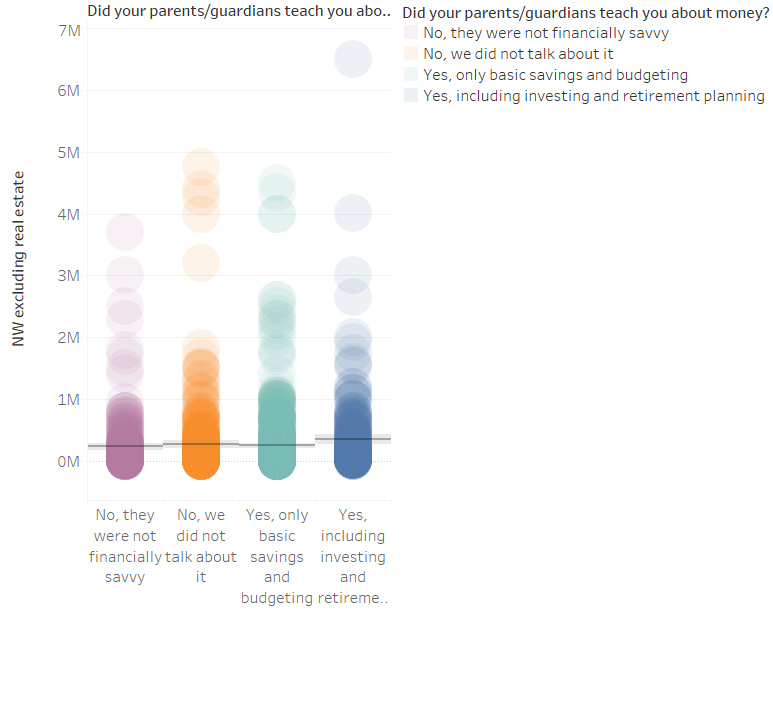

This view shows the kind of knowledge parents passed to their children and their current net worth as grown ups. The horizontal bars are the averages for each bucket, and the light grey bands represent its 95th percent confidence interval. Therefore, we can see that those who received more sophisticated instruction tend to experience better outcomes.

The next view shows that the age at which a user became financially literate has a signficant relationship to their parents' financial status:

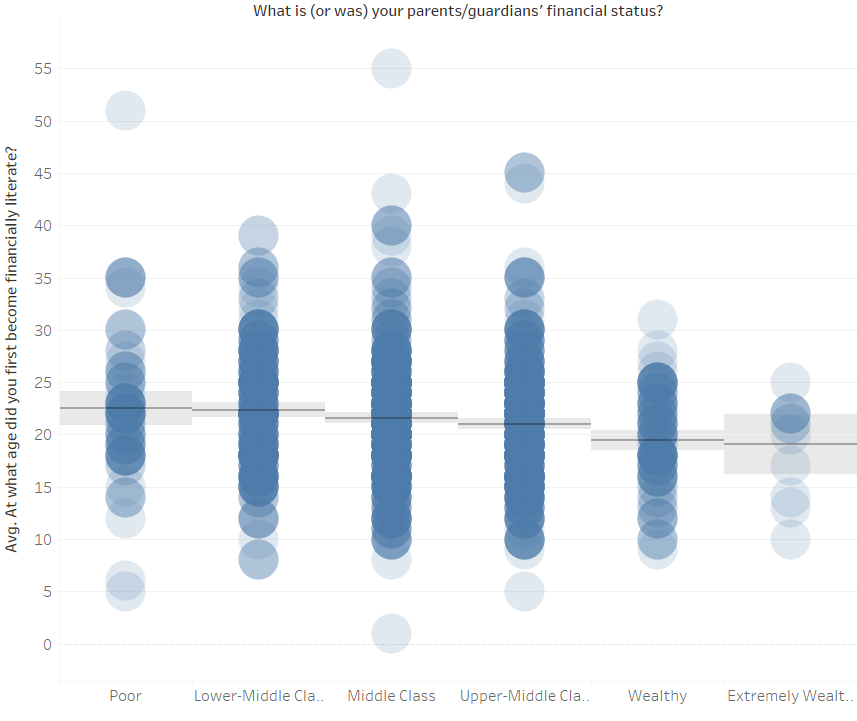

Because of the magic of compound interest, small differences in when someone starts investing can lead to large differences down the road. Sharing knowledge with your own children can make a large, though not decisive, difference in their lives. 

Make time educate them.

### 3) How does a given person compare to this group of users?

In the last section, I want to answer a question that is probably on most people's minds: how am I doing in comparison? I therfore constructed a tool that allows someone to enter their information and see how they stack up.

The tool also provides functionality to filter the users against which they wish to be compared according to features such as age, education, and the cost of living of their city. 

You can access the tool below:

In [40]:
%%HTML 
<div class='tableauPlaceholder' id='viz1573147589107' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;FI&#47;FISurveyData--PercentileCalculator&#47;PercentileCalculator&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='FISurveyData--PercentileCalculator&#47;PercentileCalculator' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;FI&#47;FISurveyData--PercentileCalculator&#47;PercentileCalculator&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1573147589107');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='1000px';vizElement.style.height='877px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>